In [18]:
import numpy as np 
import math
import os 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns 
import pickle
import pandas as pd
import time
import datetime
# sns.set()
# sns.set_style("ticks")
# sns.set_style("darkgrid")
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression,  RANSACRegressor, TheilSenRegressor, Ridge 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate, train_test_split, cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

# Data Preprocessing

In [2]:
    Dataset = r'15minute_data_newyork\15minute_data_newyork.csv'
    fulldata = pd.read_csv(Dataset) 

    # savedata = r'SaveData\\'
    # Answers = r'Hw_Results\\'

In [3]:
data=fulldata[['dataid','local_15min','grid']]

In [4]:
data['dataid'].value_counts().count()

25

In [5]:
sorteddata=data.sort_values(by = ['dataid', 'local_15min'])

In [6]:
ids=sorteddata['dataid'].unique().tolist()

In [7]:
housing_data = []
def convertDate(d):
    d = pd.to_datetime(d[:-3])
    return d 

for i in range(len(ids)):
    housing_data.append(sorteddata.loc[sorteddata.dataid==ids[i]])
    housing_data[i] = housing_data[i].reset_index().drop(columns=['index'])
    housing_data[i]['local_15min'] = housing_data[i]['local_15min'].apply(convertDate)
    #Convert datetimes to ints for regession 
    housing_data[i]['15min_ints'] =  housing_data[i]['local_15min'].map(mdates.date2num)



In [8]:
# foo = foo[:-3]

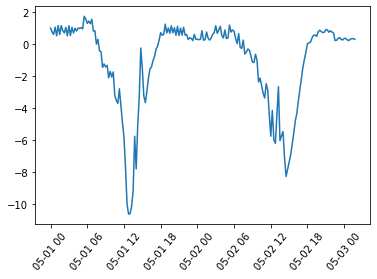

In [9]:
# housing_data[0].head(200).plot.scatter(x='local_15min', y='grid')

df = housing_data[0].head(200)
plt.xticks(rotation=50)
plt.plot(df['local_15min'], df['grid'])


In [10]:
housing_data[0]['local_15min']

0       2019-05-01 00:00:00
1       2019-05-01 00:15:00
2       2019-05-01 00:30:00
3       2019-05-01 00:45:00
4       2019-05-01 01:00:00
                ...        
17658   2019-10-31 22:45:00
17659   2019-10-31 23:00:00
17660   2019-10-31 23:15:00
17661   2019-10-31 23:30:00
17662   2019-10-31 23:45:00
Name: local_15min, Length: 17663, dtype: datetime64[ns]

In [11]:
housing_data[0]['15min_ints']

0        737180.000000
1        737180.010417
2        737180.020833
3        737180.031250
4        737180.041667
             ...      
17658    737363.947917
17659    737363.958333
17660    737363.968750
17661    737363.979167
17662    737363.989583
Name: 15min_ints, Length: 17663, dtype: float64

# Support Vector Regression 

https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html

https://towardsdatascience.com/walking-through-support-vector-regression-and-lstms-with-stock-price-prediction-45e11b620650

In [12]:
dates = housing_data[0]['15min_ints'].to_numpy()
grid_data = housing_data[0]['grid'].to_numpy()

dates = np.reshape(dates, (len(dates), 1))
grid_data = np.reshape(grid_data, (len(grid_data), 1))
last_idx = 200

In [13]:
# regress = SVR(kernel= 'rbf', C= 1, gamma= 'auto')
# regress = SVR(kernel='rbf', C=1e4, gamma=0.1)

# regress = SVR(kernel='linear')
# regress = SVR(kernel='linear', gamma='auto')
# regress = SVR(kernel='rbf', C=1e3, gamma=100)
# regress = SVR(kernel='linear', C=1e3)
# regress = SVR(kernel='rbf', C=1e3, gamma=.1)
# regress = SVR(kernel='rbf', gamma=0.2, C=100)
# regress = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
# regress =  Ridge (alpha = .5)
# regress = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="auto")
# regress = SVR(kernel='poly', C=2, degree=3, epsilon=0.0009923) #doesn't work for some reason?
regress = MultiOutputRegressor(SVR(kernel='rbf', C=1e6),n_jobs=-1)
#
#
#
#C:\Users\natha\Google Drive\Grad\Spring2021\ECE696\Project\HousingData.ipynb
#
#
#
#
#
#

#.........
# regress = tree.DecisionTreeRegressor(criterion='friedman_mse', max_depth=10)

# regress = SVR(kernel='poly', C=1000, gamma='auto', degree=3, epsilon=.1, coef0=1)

# polynomial_features  = PolynomialFeatures(degree=50,include_bias=False)
# # Regressor = RANSACRegressor(random_state=42)
# # Regressor = TheilSenRegressor(random_state=42)
# # Regressor = LinearRegression()
# regress = Pipeline([("polynomial_features", polynomial_features), ("regression", Regressor)])

last_idx = 10000
regress.fit(dates[:last_idx], grid_data[:last_idx])

# model = HWES(grid_data[:last_idx], seasonal_periods=12, trend='add', seasonal='mul')
# fitted = model.fit(optimized=True, use_brute=True)
# print(fitted.summary())
# forecast = fitted.forecast(steps=12)
# regress.fit(dates, grid_data)

score = cross_val_score(regress, dates[:last_idx], grid_data[:last_idx],scoring="neg_mean_squared_error", cv=10)

# score = cross_val_score(regress, dates[:last_idx], grid_data[:last_idx],scoring="neg_mean_squared_error", cv=10)
print(score.mean())
if abs(score.mean()) < 1: print('Good fit')

-6246.632077059282


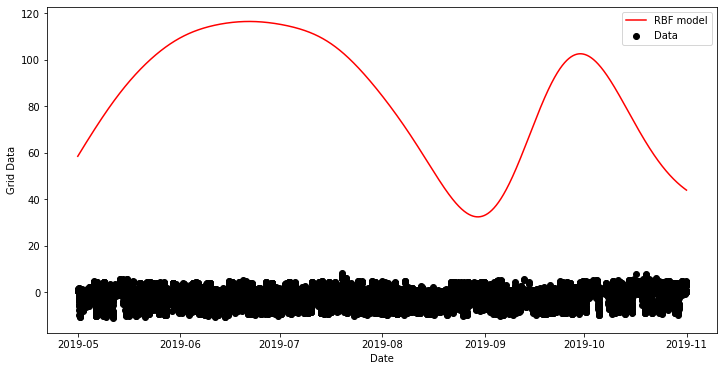

In [14]:
last_idx = -1
plt.figure(figsize = (12,6))
plt.scatter(dates[:last_idx], grid_data[:last_idx], color= 'black', label= 'Data')
plt.plot(housing_data[0]['local_15min'][:last_idx], regress.predict(dates)[:last_idx], color= 'red', label= 'RBF model') 
# plt.plot(housing_data[0]['local_15min'][:last_idx], forecast, color= 'red', label= 'RBF model') 
plt.xlabel('Date')
plt.ylabel('Grid Data')
plt.legend()
plt.show()

In [19]:
train_size = math.floor(len(grid_data) * 4/5)
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)})

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1),param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 5)})

svr.fit(X[:train_size], y[:train_size])
kr.fit(X[:train_size], y[:train_size])

NameError: name 'GridSearchCV' is not defined

In [ ]:
plt.scatter(dates[:last_idx], grid_data[:last_idx], color= 'black', label= 'Data')
plt.plot(housing_data[0]['local_15min'][:last_idx], svr.predict(dates)[:last_idx], color= 'red', label= 'svr model') 
plt.plot(housing_data[0]['local_15min'][:last_idx], kr.predict(dates)[:last_idx], color= 'blue', label= 'kr model') 
